### Algorithms:
- Linear Regression
- Classification
- Clustering
- Hidden Markov Models

## Linear Regression
Linear regression is one of the most basic forms of machine learning and is used to predict numeric values.

Linear regression follows a very simple concept. If data points are related linearly, we can generate a **line of best fit** for these points and use it to predict future values.

**line of best fit**: *Line of best fit refers to a line through a scatter plot of data points that best expresses the relationship between those points.*
- y=mx+b

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

#### Dataset

In [2]:
# Load data
data_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
data_eval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data

# When we have information and data like this, we don't necessarily know what correlations there might be. But we can kind of
# assume there's some linear thing that we're looking for, some kind of pattern. 
data_train.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [3]:
# Now, we need to separate the data we're going to be classifying from the data that is kind of our input information or an 
# initial dataset. So, since we're looking for the 'survived' information, we're going to put that in its own kind of variable
y_train = data_train.pop('survived')
y_eval = data_eval.pop('survived')

In [4]:
# To see an specific row in data train we use:
print(data_train.loc[0], y_train.loc[0])
# Doing this we're getting the information of the fisrt person and if that person survived or not.

sex                          male
age                            22
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


In [5]:
data_train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


### Note: 
**Bias**: error persistente que comete el algoritmo de aprendizaje sobre el problema

### And now because visuals are always valuable let's generate a few graphs of the data.

<AxesSubplot:>

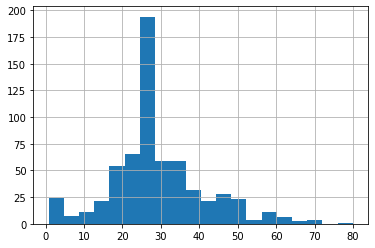

In [6]:
data_train['age'].hist(bins=20)

<AxesSubplot:>

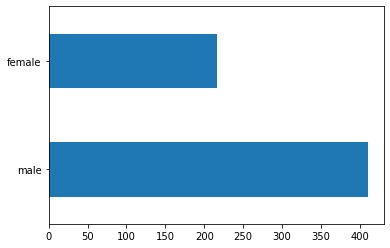

In [7]:
data_train['sex'].value_counts().plot(kind='barh')

<AxesSubplot:>

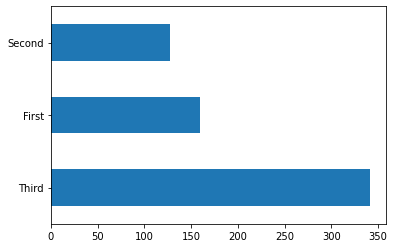

In [8]:
data_train['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survived')

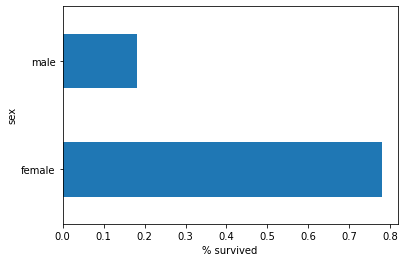

In [9]:
# Survival rate by sex
pd.concat([data_train, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived')

Text(0.5, 0, '% survived')

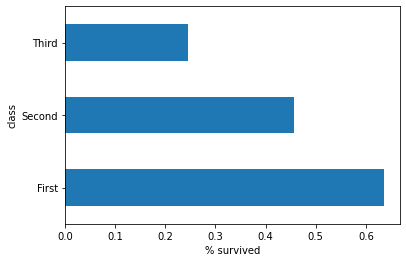

In [10]:
# Survival rate by class
pd.concat([data_train, y_train], axis=1).groupby('class').survived.mean().plot(kind='barh').set_xlabel('% survived')

After analyzing this information, we should notice the following:
- Most passengers are in their 20's or 30's
- Most passengers are male
- Most passengers are in "Third" class
- Females have a much higher chance of survival

### Training vs Test Data

The training data is what we feed to the model so that it can develop and learn. It is usually a much larger size than the testing data.

The testing data is what we use to evaulate the model and see how well it is performing. We must use a seperate set of data that the model has not been trained on to evaluate it.

In [11]:
categorical_columns = ['sex', 'class', 'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'n_siblings_spouses', 'parch', 'fare']

feature_columns = []
for feature_name in categorical_columns:
    vocabulary = data_train[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
    
for feature_name in numeric_columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype = tf.float32))
    
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='n_siblings_spouses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='parch', shape=(1,)

### The Training Process
Explain how our model is trained. Specifically, how input data is fed to our model.

For this specific model data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries. We will feed these batches to our model multiple times according to the number of epochs.

An epoch is simply one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.

Ex. if we have 10 ephocs, our model will see the same dataset 10 times.

Since we need to feed our data in batches and multiple times, we need to create something called an **input function**. The input function simply defines how our dataset will be converted into batches at each epoch.

In [12]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(data_train, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(data_eval, y_eval, num_epochs=1, shuffle=False)

### Creating the Model

In [13]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Jhon\\AppData\\Local\\Temp\\tmpi3dfswxq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training the Model

In [14]:
linear_est.train(train_input_fn) # train

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.


C:\Users\Jhon\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Jhon\AppData\Local\Temp\tmpi3dfswxq\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 390.309
INFO:tensorflow:loss = 0.9841424, step = 100 (0.258 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into C:\Users\Jhon\AppData\Local\Temp\tmpi3dfswxq\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...
INFO:tensorflow:Loss for fin

### Evaluating the Model

In [15]:
result = linear_est.evaluate(eval_input_fn) # get model stats by testing on testing data
clear_output() # clear console output
print(result['accuracy']) # result is a dict of stats about our model, so we check the accuracy we got

0.7651515


In [16]:
result

{'accuracy': 0.7651515,
 'accuracy_baseline': 0.625,
 'auc': 0.83777165,
 'auc_precision_recall': 0.7912662,
 'average_loss': 0.47196367,
 'label/mean': 0.375,
 'loss': 0.45943552,
 'precision': 0.69473684,
 'prediction/mean': 0.38132837,
 'recall': 0.6666667,
 'global_step': 200}

### Predictions

In [21]:
predict = list(linear_est.predict(eval_input_fn))
predict[0]['probabilities'] # predict[0]['probabilities'][0] Not survived

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Jhon\AppData\Local\Temp\tmpi3dfswxq\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([0.9246431 , 0.07535695], dtype=float32)

In [28]:
# Compare with actual results
print(data_eval.loc[5], y_eval.loc[5])
print("Probability of surviving:", predict[5]['probabilities'][1])

sex                       female
age                           15
n_siblings_spouses             0
parch                          0
fare                      8.0292
class                      Third
deck                     unknown
embark_town           Queenstown
alone                          y
Name: 5, dtype: object 1
Probabily of surviving: 0.711037
